In [3]:
import os
import pandas as pd
import numpy as np


Pulling in the data for each event, concatenating each event into one dataset, and subsetting to a new df with the search and destroy matches.

In [4]:
EVENT_FOLDER = './events_csv'
EVENT_FILES = os.listdir(EVENT_FOLDER)

event_list = []
event_names = ['Dallas', 'New Orleans', 'Atlanta', 'Birmingham', ' Pro League 1', 'Relegation', 'Seattle',
               'Anaheim', 'Pro League 2', 'Champs']
event_dict = {}
ww2_snd = []

for x in EVENT_FILES:
    with open('{}/{}'.format(EVENT_FOLDER, x)) as f:
        temp = pd.read_csv(f)
        event_list.append(temp)

event_dict = dict(zip(event_names, event_list))

meta_df = pd.concat(event_list[:])

ww2_snd = meta_df[meta_df['mode'] == 'Search & Destroy']

Grouping by favorite weapon to get the comprehensive average of each weapon for average kills per round (akpr), average shots per round (aspr), average time per life (atpl), and avg score streaks earned (aste). This will allow to normalize ratings by gun so that players that use a specific weapon are not negatively impacted.

The first step is to determine the target stats that will be used in the model. Then a single stat (avg kills per round) will be analyzed before analyze each of the other statistics.

In [152]:
w_df = ww2_snd[:]
#print(list(w_df))
target_stats = ['match id','player', 'fave weapon', 'kills', 'kills (stayed alive)', 'shots', 'avg time per life (s)',
                'snd rounds', 'snd firstbloods', 'scorestreaks earned']
by_weapon = w_df[target_stats]
#print(by_weapon.head())


Next step is to find the weapons which were involved in less than 25 snd rounds. Most of these weapons stats do not have enough volume to be incorporated and skew the data away from a normal distribution. For this initial analyses we will be using only the akpr before moving to analyze the other stats. There is imortant information to discern as it impact the methodology going forward in incorporating eachs stat.

In [26]:
test = by_weapon.groupby('fave weapon')['kills', 'snd rounds'].sum()
test['akpr.w'] = test['kills']/test['snd rounds']
print(test)

             kills  snd rounds    akpr.w
fave weapon                             
BAR           2742        3876  0.707430
FG 42         4800        6679  0.718670
Kar98k        1119        1501  0.745503
M1 Garand       20          20  1.000000
M1941            3           9  0.333333
PPSh-41      17194       25325  0.678934
STG-44       19523       28237  0.691398
Springfield   1674        2185  0.766133


M1 Garand and M1941 need to removed based on their round uses being less than 25 rounds. Additionally, you can see that these two weapons also seem to be outliers to the data which is the same reason they will be removed. We can't just drop these rows from the test dataframe as they were used in the calculation for the akpr.w and would skew the results (later on it will disturb the mean from sitting at 0 in future 'residual' calculations).

             kills  snd rounds    akpr.w
fave weapon                             
BAR           2742        3876  0.707430
FG 42         4800        6679  0.718670
Kar98k        1119        1501  0.745503
PPSh-41      17194       25325  0.678934
STG-44       19523       28237  0.691398
Springfield   1674        2185  0.766133
0.7180113654208206


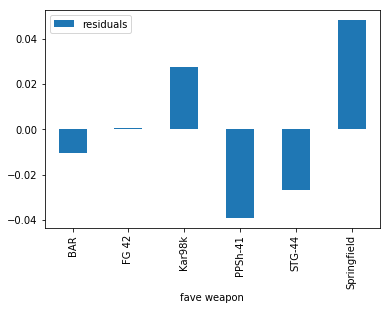

In [68]:
weapon_drop = by_weapon[~by_weapon['fave weapon'].isin(['M1 Garand', 'M1941'])]
clean_weapon = weapon_drop.groupby('fave weapon')['kills', 'snd rounds'].sum()
clean_weapon['akpr.w'] = clean_weapon['kills']/clean_weapon['snd rounds']
print(clean_weapon)
mu_akpr = clean_weapon['akpr.w'].mean()
print(mu_akpr)
clean_weapon['residuals'] = clean_weapon['akpr.w']-mu_akpr
clean_weapon.plot.bar(y='residuals')


From looking at the residual plot, it becomes obvious that the snipers (Kar98k, Springfield) could possibly be distorting the usefulness of the mean and what it is being used for in the model. While a good sniper will have a strong impact upon a match, these two weapons were also the lease used. As seen above they were used a signifigant amount, but no where near the magnitude of other weapons. Lets look at the data and residual plot without these weapons included.

             kills  snd rounds    akpr.w
fave weapon                             
BAR           2742        3876  0.707430
FG 42         4800        6679  0.718670
PPSh-41      17194       25325  0.678934
STG-44       19523       28237  0.691398
0.6991081178528658


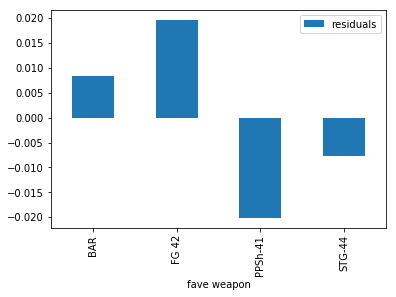

In [69]:
weapon_drop2 = by_weapon[~by_weapon['fave weapon'].isin(['M1 Garand', 'M1941', 'Kar98k', 'Springfield'])]
clean_weapon2 = weapon_drop2.groupby('fave weapon')['kills', 'snd rounds'].sum()
clean_weapon2['akpr.w'] = clean_weapon2['kills']/clean_weapon2['snd rounds']
print(clean_weapon2)
mu_akpr2 = clean_weapon2['akpr.w'].mean()
print(mu_akpr2)
clean_weapon2['residuals'] = clean_weapon2['akpr.w']-mu_akpr2
clean_weapon2.plot.bar(y='residuals')

As seen in this new graph, the BAR and FG 42 are now positive. These residuals are also interesting as the ppsh-41 and STG-44 are negative. This could mean a number of things but this could infer that these players tend to take more risks or play more aggresive (most likely explination) as part of their designed roles with these weapons. It is probably necessary to remove this bias from their rating. Adjusting for these role biases, the percent difference between the mean and the actual value per each weapon will be positively applied for each of the negative weapons (boost them to mean of 0) and negatively applied for each positive weapon (reduce to mean of 0). This "role adjustment" will normalize stats to remove role biases and will be done for each stat that will be analyzed next and included in the model. As we move forward, each dataframe containing a stat analyzed will be saved to a list for column binding later. This will be the easiest method for moving forward conhesively and keeping track of the appropriate dataframes.

Next we will look at firstbloods (first kill in the round) which is an extremely impactful engagement upon winning a round. 

             snd firstbloods  snd rounds
fave weapon                             
BAR                      425        3876
FG 42                    799        6679
Kar98k                   244        1501
M1 Garand                  2          20
M1941                      0           9
PPSh-41                 3290       25325
STG-44                  3277       28237
Springfield              385        2185
['Kar98k', 'Springfield', 'M1 Garand', 'M1941']


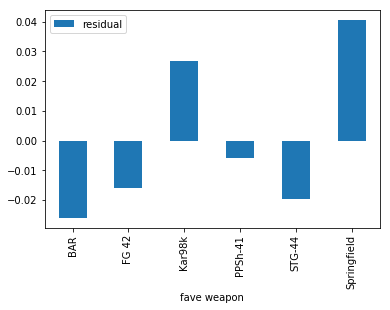

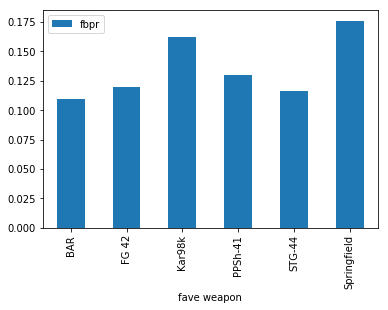

In [99]:
stat_df_track = [clean_weapon, clean_weapon2]

first_blood = w_df.groupby('fave weapon')['snd firstbloods', 'snd rounds'].sum()
print(first_blood)

#creating lists of weapons to drop
n2low = ['M1 Garand', 'M1941']
distort = ['Kar98k', 'Springfield'] + n2low
print(distort)

snd_fb_drop = w_df[~w_df['fave weapon'].isin(n2low)].groupby('fave weapon')['snd firstbloods', 'snd rounds'].sum()
snd_fb_drop['fbpr'] = snd_fb_drop['snd firstbloods']/snd_fb_drop['snd rounds']
mu_fbpr = snd_fb_drop['fbpr'].mean()
snd_fb_drop['residual'] = snd_fb_drop['fbpr']-mu_fbpr
snd_fb_drop.plot.bar(y='residual')
snd_fb_drop.plot.bar(y='fbpr')


Althought the snipers are distorting the use of the mean again, they tell a story about this statistic. In following the pattern of plotting the residual, they both are positive causing the other weapons to be negative around the mean. Thinking about this further, this could insinuate that snipers have a higher occurence of getting firstbloods in a round. Plotting the fbpr shows this to be true. The next step is to analyze the residuals without the snipers included. Further analysis on how to incorporate snipers might need to be taken into account.

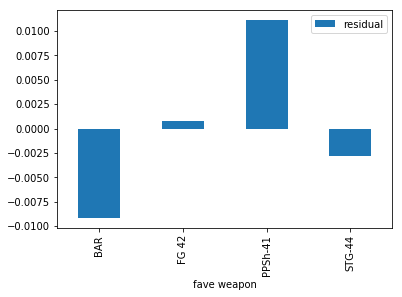

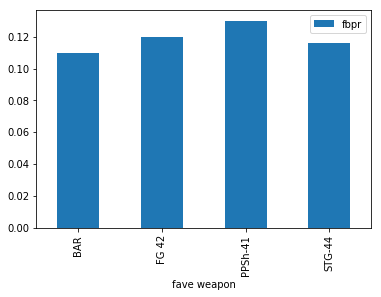

In [174]:
snd_fb_drop2 = w_df[~w_df['fave weapon'].isin(distort)].groupby('fave weapon')['snd firstbloods', 'snd rounds'].sum()
snd_fb_drop2['fbpr'] = snd_fb_drop2['snd firstbloods']/snd_fb_drop2['snd rounds']
mu_fbpr2 = snd_fb_drop2['fbpr'].mean()
snd_fb_drop2['residual'] = snd_fb_drop2['fbpr']-mu_fbpr2
snd_fb_drop2.plot.bar(y='residual')
snd_fb_drop2.plot.bar(y='fbpr')


Moving on to scorestreaks earned.

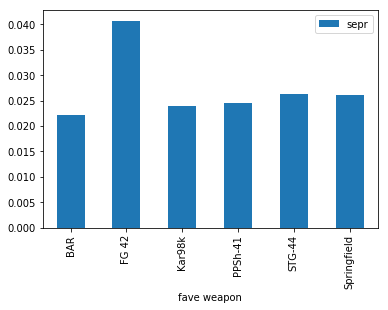

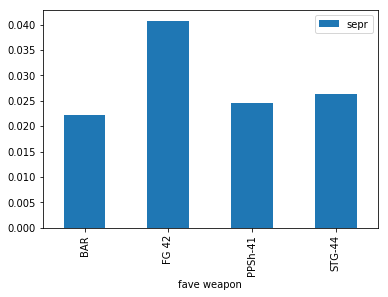

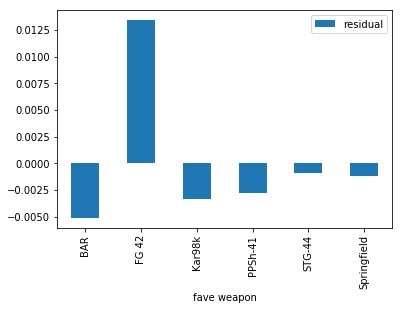

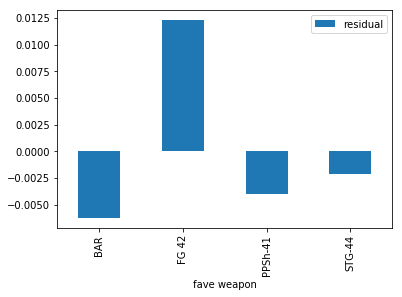

In [110]:
stat_df_track = stat_df_track + [snd_fb_drop,snd_fb_drop2]

se = w_df[~w_df['fave weapon'].isin(n2low)].groupby('fave weapon')['scorestreaks earned', 'snd rounds'].sum()
se['sepr'] = se['scorestreaks earned']/se['snd rounds']
mu_sepr = se['sepr'].mean()
se['residual'] = se['sepr']-mu_sepr

se2 = w_df[~w_df['fave weapon'].isin(distort)].groupby('fave weapon')['scorestreaks earned', 'snd rounds'].sum()
se2['sepr'] = se2['scorestreaks earned']/se2['snd rounds']
mu_sepr2 = se2['sepr'].mean()
se2['residual'] = se2['sepr']-mu_sepr2


se.plot.bar(y='sepr')
se2.plot.bar(y='sepr')
se.plot.bar(y='residual')
se2.plot.bar(y='residual')

Moving on to average time per life.

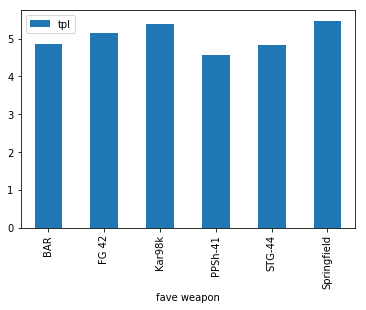

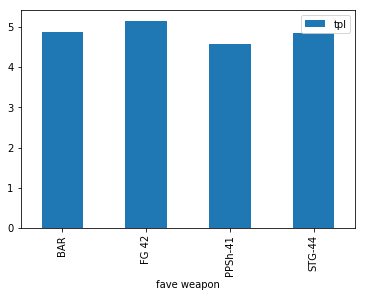

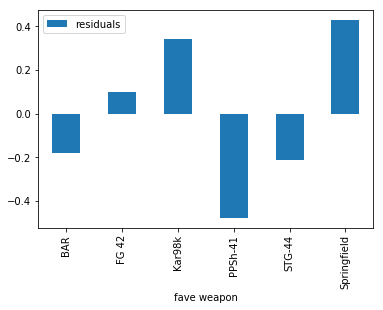

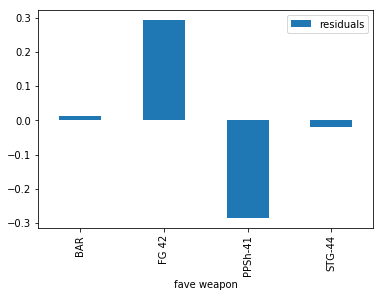

In [173]:
stat_df_track = stat_df_track + [se, se2]

w_df.rename(columns= {'avg time per life (s)': 'avg_tpl'}, inplace=True)
w_df['avg_tpl'] = pd.to_numeric(w_df['avg_tpl'], errors='coerce')

time_pl = w_df[~w_df['fave weapon'].isin(n2low)].groupby('fave weapon')['avg_tpl', 'snd rounds'].sum()
time_pl['tpl'] = time_pl['avg_tpl']/time_pl['snd rounds']
tpl_mu = time_pl.tpl.mean()
time_pl['residuals'] = time_pl.tpl-tpl_mu

time_pl2 = w_df[~w_df['fave weapon'].isin(distort)].groupby('fave weapon')['avg_tpl', 'snd rounds'].sum()
time_pl2['tpl'] = time_pl2['avg_tpl']/time_pl2['snd rounds']
tpl_mu2 = time_pl2.tpl.mean()
time_pl2['residuals'] = time_pl2.tpl-tpl_mu2

time_pl.plot.bar(y='tpl')
time_pl2.plot.bar(y='tpl')
time_pl.plot.bar(y='residuals')
time_pl2.plot.bar(y='residuals')
